## **Face Recognition**

**Facial Recognition System** is a technology capable of matching a human face from a digital image or a video frame against a database of faces, typically employed to authenticate users through ID verification services, works by pinpointing and measuring facial features from a given image. 

We'll be building a face recognition model that uses **Siamese Networks** to give us a distance value that indicates whether 2 images are same or different. 

#### **The Dataset**
We'll be using the **Extracted Faces** from **face-recognition-dataset**, which is derived from the **LFW Dataset**.
The Extracted Faces contains faces extracted from the base images using **Haar-Cascade Face-Detection** (CV2).
- The dataset contains 1324 different individuals, with 2-50 images per person.
- The images are of size (128,128,3) and are encoded in RGB.
- Each folder and image is named with a number, i.e 0.jpg, 1.jpg

## **Reading the Dataset**

We're reading the folders and splitting them into **train and test set** for training purposes.

In [1]:
import os
import cv2
import ast
import time
import random
import numpy as np
import pandas as pd

#for the pre-trained model
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception,resnet50
from tensorflow.keras.models import Model, Sequential

#for plotting
import seaborn as sns
import matplotlib.pyplot as plt
tf.__version__, np.__version__



#for data augmentation
from skimage.transform import rotate, rescale
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
from skimage.filters import gaussian
from PIL import Image, ImageEnhance

#for evaluation metrics
from tensorflow.keras import backend, layers, metrics
from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, log_loss

#for face detection and alignment
from numpy import loadtxt
!pip install deepface
from deepface import DeepFace
from deepface.commons import functions
from PIL import Image

#for the live demo
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import PIL
from PIL import *
import io
import html
import time


#for google drive access
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d stoicstatic/face-recognition-dataset
!unzip /content/face-recognition-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Face Data/Face Dataset/1618/0.jpg  
  inflating: Face Data/Face Dataset/1618/1.jpg  
  inflating: Face Data/Face Dataset/1618/2.jpg  
  inflating: Face Data/Face Dataset/1619/0.jpg  
  inflating: Face Data/Face Dataset/1619/1.jpg  
  inflating: Face Data/Face Dataset/1619/2.jpg  
  inflating: Face Data/Face Dataset/1619/3.jpg  
  inflating: Face Data/Face Dataset/1619/4.jpg  
  inflating: Face Data/Face Dataset/162/0.jpg  
  inflating: Face Data/Face Dataset/162/1.jpg  
  inflating: Face Data/Face Dataset/162/2.jpg  
  inflating: Face Data/Face Dataset/1620/0.jpg  
  inflating: Face Data/Face Dataset/1620/1.jpg  
  inflating: Face Data/Face Dataset/1621/0.jpg  
  inflating: Face Data/Face Dataset/1621/1.jpg  
  inflating: Face Data/Face Dataset/1621/2.jpg  
  inflating: Face Data/Face Dataset/1621/3.jpg  
  inflating: Face Data/Face Dataset/1621/4.jpg  
  inflating: Face Data/Face Dataset/1621/5.jpg  
  inflating: Face Dat

In [4]:
# Setting random seeds to enable consistency while testing.
random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)


ROOT = "/content/Extracted Faces/Extracted Faces"
ROOT_2 = "/content/Test"

def read_image(index):
    path = os.path.join(ROOT, index[0], index[1])
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def read_image_mod(index):
    path = os.path.join(ROOT_2, index[0], index[1])
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image
    

In [5]:
# def split_dataset(directory, split=0.8):
#     folders = os.listdir(directory)
#     num_train = int(len(folders)*split)
    
#     random.shuffle(folders)
    
#     train_list, test_list = {}, {}
    
#     # Creating Train-list
#     for folder in folders[:num_train]:
#         num_files = len(os.listdir(os.path.join(directory, folder)))
#         train_list[folder] = num_files
    
#     # Creating Test-list
#     for folder in folders[num_train:]:
#         num_files = len(os.listdir(os.path.join(directory, folder)))
#         test_list[folder] = num_files  
    
#     return train_list, test_list

# train_list, test_list = split_dataset(ROOT, split=0.8)

# print("Length of training list:", len(train_list))
# print("Length of testing list :", len(test_list))

# # train_list, test list contains the folder names along with the number of files in the folder.
# print("\nTest List:", test_list)

# **new split**

In [6]:
def split_dataset(directory, split=(0.8, 0.1, 0.1)):
    folders = os.listdir(directory)
    num_train = int(len(folders)*split[0])
    num_val = int(len(folders)*split[1])
    
    random.shuffle(folders)
    
    train_list, val_list, test_list = {}, {}, {}
    
    # Creating Train-list
    for folder in folders[:num_train]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        train_list[folder] = num_files
    
    # Creating Validation-list
    for folder in folders[num_train:num_train+num_val]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        val_list[folder] = num_files 
        
    # Creating Test-list
    for folder in folders[num_train+num_val:]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        test_list[folder] = num_files  
    
    return train_list, val_list, test_list


train_list, val_list, test_list = split_dataset(ROOT, split=(0.8, 0.1, 0.1))

print("Length of training list:", len(train_list))
print("Length of validation list:", len(val_list))
print("Length of testing list :", len(test_list))

# train_list, val_list, and test_list contain the folder names along with the number of files in the folder.
print("\nValidation List:", val_list)


Length of training list: 1059
Length of validation list: 132
Length of testing list : 133

Validation List: {'1116': 5, '354': 3, '1538': 3, '1298': 4, '1490': 24, '67': 2, '839': 2, '94': 2, '1332': 13, '870': 3, '790': 2, '1039': 2, '687': 2, '708': 17, '1443': 2, '969': 3, '488': 2, '612': 2, '678': 2, '1652': 21, '843': 3, '440': 2, '1521': 2, '476': 3, '869': 3, '304': 6, '263': 5, '945': 2, '1406': 5, '660': 3, '931': 39, '133': 2, '563': 2, '1489': 2, '1600': 2, '541': 3, '594': 3, '976': 6, '1459': 3, '1366': 2, '1398': 6, '188': 4, '944': 4, '858': 7, '936': 2, '183': 6, '120': 2, '1159': 3, '617': 2, '1090': 3, '191': 2, '1154': 4, '630': 2, '339': 2, '1645': 7, '1654': 3, '536': 46, '298': 2, '746': 4, '1173': 2, '1133': 2, '178': 2, '1289': 2, '741': 2, '1235': 2, '957': 2, '524': 4, '1242': 2, '1256': 8, '1609': 2, '782': 13, '520': 9, '994': 38, '1277': 3, '91': 3, '811': 2, '301': 4, '1374': 3, '748': 2, '1605': 7, '1630': 3, '528': 3, '1376': 3, '1075': 7, '395': 3, '16

### Creating Triplets

We use the train and test list to create triplets of **(anchor, postive, negative)** face data, where positive is the same person and negative is a different person than anchor.

In [7]:
def create_triplets(directory, folder_list, max_files=10):
    triplets = []
    folders = list(folder_list.keys())
    
    for folder in folders:
        path = os.path.join(directory, folder)
        files = list(os.listdir(path))[:max_files]
        num_files = len(files)
        
        for i in range(num_files-1):
            for j in range(i+1, num_files):
                anchor = (folder, f"{i}.jpg")
                positive = (folder, f"{j}.jpg")

                neg_folder = folder
                while neg_folder == folder:
                    neg_folder = random.choice(folders)
                neg_file = random.randint(0, folder_list[neg_folder]-1)
                negative = (neg_folder, f"{neg_file}.jpg")

                triplets.append((anchor, positive, negative))
            
    random.shuffle(triplets)
    return triplets

In [8]:
# train_triplet = create_triplets(ROOT, train_list)

# test_triplet  = create_triplets(ROOT, test_list)

# val_triplet = create_triplets(ROOT, val_list)

#loading the csv files that represent the triplets for the train,valid, and test datasets

df = pd.read_csv("/content/drive/MyDrive/deep learning/data csv /train_df.csv")
df = df.applymap(ast.literal_eval)
train_triplet = tuple(zip(df['0'], df['1'], df['2']))

df = pd.read_csv("/content/drive/MyDrive/deep learning/data csv /valid_df.csv")
df = df.applymap(ast.literal_eval)
val_triplet = tuple(zip(df['0'], df['1'], df['2']))

df = pd.read_csv("/content/drive/MyDrive/deep learning/data csv /test_df.csv")
df = df.applymap(ast.literal_eval)
test_triplet = tuple(zip(df['0'], df['1'], df['2']))


print("Number of training triplets:", len(train_triplet))
print("Number of testing triplets :", len(test_triplet))
print("Number of validation triplets :", len(val_triplet))

print("\nExamples of train triplets:")
for i in range(5):
    print(train_triplet[i])

print("\nExamples of val triplets:")
for i in range(5):
    print(val_triplet[i])


print("\nExamples of test triplets:")
for i in range(5):
    print(test_triplet[i])

Number of training triplets: 8776
Number of testing triplets : 1275
Number of validation triplets : 1180

Examples of train triplets:
(('779', '0.jpg'), ('779', '6.jpg'), ('1458', '1.jpg'))
(('755', '5.jpg'), ('755', '8.jpg'), ('1302', '0.jpg'))
(('312', '2.jpg'), ('312', '4.jpg'), ('1099', '1.jpg'))
(('634', '7.jpg'), ('634', '9.jpg'), ('875', '0.jpg'))
(('833', '2.jpg'), ('833', '4.jpg'), ('1666', '2.jpg'))

Examples of val triplets:
(('709', '3.jpg'), ('709', '4.jpg'), ('523', '3.jpg'))
(('408', '2.jpg'), ('408', '8.jpg'), ('1170', '7.jpg'))
(('408', '1.jpg'), ('408', '7.jpg'), ('957', '1.jpg'))
(('1605', '0.jpg'), ('1605', '2.jpg'), ('1156', '0.jpg'))
(('1253', '3.jpg'), ('1253', '6.jpg'), ('991', '0.jpg'))

Examples of test triplets:
(('1088', '1.jpg'), ('1088', '6.jpg'), ('536', '21.jpg'))
(('395', '1.jpg'), ('395', '2.jpg'), ('1519', '1.jpg'))
(('418', '1.jpg'), ('418', '2.jpg'), ('1557', '11.jpg'))
(('1332', '5.jpg'), ('1332', '6.jpg'), ('696', '0.jpg'))
(('1629', '7.jpg'), ('1

In [9]:
# train_df = pd.DataFrame(train_triplet)
# valid_df = pd.DataFrame(val_triplet)
# test_df = pd.DataFrame(test_triplet)

# train_df.to_csv("/content/drive/MyDrive/deep learning/data csv /train_df.csv", index=False)
# valid_df.to_csv("/content/drive/MyDrive/deep learning/data csv /valid_df.csv", index=False)
# test_df.to_csv("/content/drive/MyDrive/deep learning/data csv /test_df.csv", index=False)


### Creating Batch-Generator

Creating a **Batch-Generator** that converts the triplets passed into batches of face-data and **preproccesses** it before returning the data into seperate lists.

**Parameters:**
- Batch_size: Batch_size of the data to return
- Preprocess: Whether to preprocess the data or not

In [10]:
# def get_batch(triplet_list, batch_size=256, preprocess=True):
#     batch_steps = len(triplet_list)//batch_size
    
#     for i in range(batch_steps+1):
#         anchor   = []
#         positive = []
#         negative = []
        
#         j = i*batch_size
#         while j<(i+1)*batch_size and j<len(triplet_list):
#             a, p, n = triplet_list[j]
#             anchor.append(read_image(a))
#             positive.append(read_image(p))
#             negative.append(read_image(n))
#             j+=1
            
#         anchor = np.array(anchor)
#         positive = np.array(positive)
#         negative = np.array(negative)
        
#         if preprocess:
#             anchor = preprocess_input(anchor)
#             positive = preprocess_input(positive)
#             negative = preprocess_input(negative)
        
#         yield ([anchor, positive, negative])

# **Augmentation**

In [11]:
import random
import numpy as np
from skimage.transform import rotate, rescale
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
from skimage.filters import gaussian
from PIL import Image, ImageEnhance

def transform_image(img):
    # apply random horizontal flip with a 50% chance
    if random.random() < 0.5:
        img = np.fliplr(img)
    
        
    # apply random rotation between -10 and 10 degrees
    angle = random.uniform(-10, 10)
    img = rotate(img, angle)
    
    # apply random zoom between 0.9 and 1.1
    
    zoom = random.uniform(0.9, 1.1)
    img = rescale(img, 1.0)
    
    
    # apply random brightness adjustment between -0.1 and 0.1
    brightness = random.uniform(-0.1, 0.1)
    img = adjust_gamma(img, 1+brightness)
    
    # apply random color distortion with a 30% chance
    if random.random() < 0.3:
        img = random_noise(img, mode='speckle', var=0.1)
    
    # apply random blur with a 30% chance
    if random.random() < 0.3:
        img = gaussian(img, sigma=random.uniform(0.1, 1.0), channel_axis=True)

    img = img * 255
    img = img.astype(int)
    img.resize(128,128,3)
    
    return img


In [12]:
def get_Images_Anc(triplet_list,batch_size=256):
    batch_steps = len(triplet_list)//batch_size
  
    for i in range(batch_steps+1):
        anchor   = []
        
        j = i*batch_size
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p, n = triplet_list[j]
            anchor.append(read_image(a))
            j+=1
     

        
        return anchor

In [13]:
def get_batch(triplet_list, batch_size=256, preprocess=True, augment = False,shuffle = False,ScaleOfAugmentation = 6):
    batch_steps = len(triplet_list)//batch_size
    if(shuffle):
      triplet_list = tuple(random.sample(triplet_list, len(triplet_list)))
    # print(len(triplet_list))
    # triplet_list = random.shuffle(triplet_list)
    # yesCount=0
    # noCount=0
    for i in range(batch_steps+1):
        anchor   = []
        positive = []
        negative = []
        
        j = i*batch_size
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p, n = triplet_list[j]
            anchor.append(read_image(a))
            #print("before",read_image(a).shape,np.max(read_image(a)),np.min(read_image(a)))
            positive.append(read_image(p))
            negative.append(read_image(n))
            

            if augment:
              if(random.randint(0,10)<=ScaleOfAugmentation):
              # apply random transformations to the images
                a_1 = transform_image(read_image(a))
                p_1 = transform_image(read_image(p))
                n_1 = transform_image(read_image(n))
                #print("after", a_1.shape, np.max(a_1),np.min(a_1))
                anchor.append(a_1)
                positive.append(p_1)
                negative.append(n_1)
                # yesCount+=1
              # else:
                # noCount+=1
            j+=1

        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)
        
        if preprocess:
            anchor = preprocess_input(anchor)
            positive = preprocess_input(positive)
            negative = preprocess_input(negative)
        
        yield ([anchor, positive, negative])

### Plotting the Data

Plotting the data generated from **get_batch()** to see the results

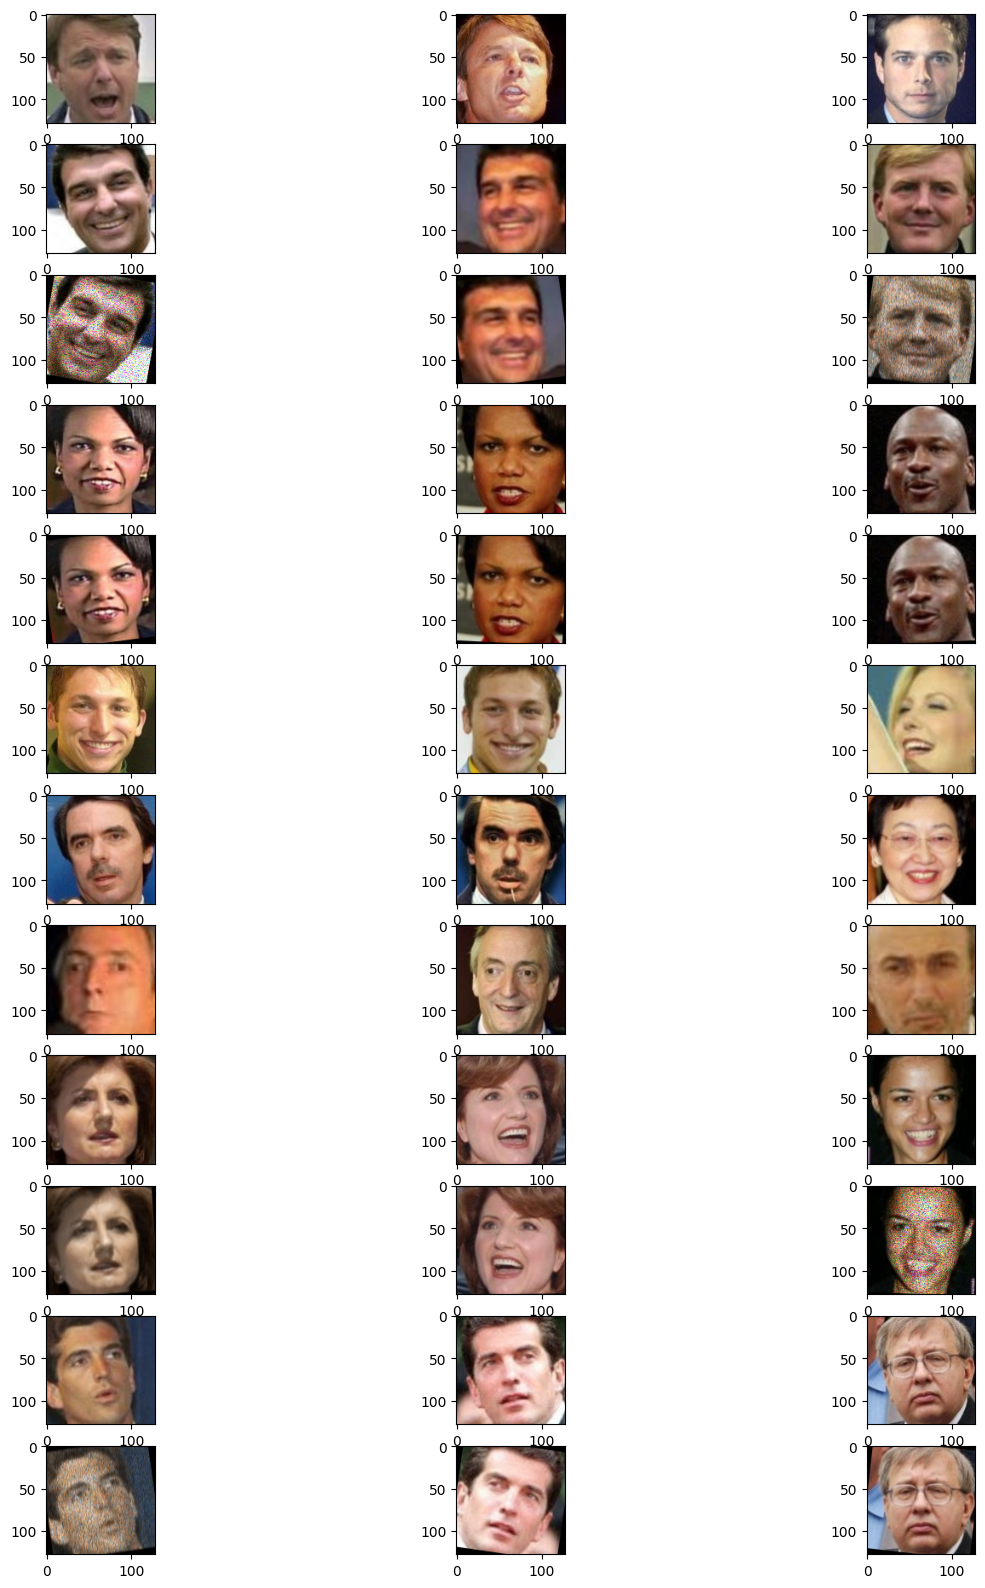

In [14]:
num_plots = 12

f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))

for x in get_batch(train_triplet, batch_size=num_plots, preprocess=False,augment = True):
    a,p,n = x
    for i in range(num_plots):
        axes[i, 0].imshow(a[i])
        axes[i, 1].imshow(p[i])
        axes[i, 2].imshow(n[i])
        i+=1
    break

## **Creating the Model**

Unlike a conventional CNN, the **Siamese Network** does not classify the images into certain categories or labels, rather it only finds out the distance between any two given images. If the images have the same label, then the network should learn the parameters, i.e. the weights and the biases in such a way that it should produce a smaller distance between the two images, and if they belong to different labels, then the distance should be larger

![Siamese Network Image](https://miro.medium.com/max/2000/1*05hUCDHhnl4hdjqvdVTHtw.png)

In [15]:
from tensorflow.keras import backend, layers, metrics

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception,resnet50
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

### Encoder

The **Encoder** is responsible for converting the passed images into their feature vectors. We're using a pretrained model, **Xception model** which is based on **Inception_V3 model.** By using transfer learning, we can significantly reduce the training time and size of the dataset.

The Model is connected to **Fully Connected (Dense)** layers and the last layer normalises the data using **L2 Normalisation**. *(L2 Normalisation is a technique that modifies the dataset values in a way that in each row the sum of the squares will always be up to 1)*

In [16]:
# pretrained_model =resnet50.ResNet50(
#     include_top=False,
#     weights='imagenet',
#     input_shape=input_shape,
#     pooling="max"
#     )

# pretrained_model.summary()

In [17]:
def get_encoder(input_shape):
    """ Returns the image encoding model """

    pretrained_model = Xception(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg', #max instead of avg
    )


    for i in range(len(pretrained_model.layers)-35): #instead of 27
        pretrained_model.layers[i].trainable = False

    encode_model = Sequential([
        pretrained_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'), #tried tanh and reached 89% acc on test 
        layers.BatchNormalization(),
        layers.Dense(256, activation="relu"),
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) 
    ], name="Encode_Model")
    return encode_model

### Siamese Network

We're creating a **Siamese Network** that takes 3 input images, (anchor, postive, negative) and uses the encoder above to encode the images to their feature vectors. Those features are passed to a distance layer which computes the distance between **(anchor, positive)** and **(anchor, negative)** pairs.

We'll be defining a custom layer to compute the distance.

**Distance Formula**:

![image.png](attachment:5e83389c-697d-4b02-8b39-81f5eba0ba9e.png)

In [18]:
class DistanceLayer(layers.Layer):
    #A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)
        

def get_siamese_network(input_shape = (128, 128, 3)):
    encoder = get_encoder(input_shape)

    #encoder.assert_consumed()
    
    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")
    
    ## Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)
    
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(
        encoder(anchor_input),
        encoder(positive_input),
        encoder(negative_input)
    )
    
    # Creating the Model
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network

siamese_network = get_siamese_network()
siamese_network.summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Anchor_Input (InputLayer)      [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Positive_Input (InputLayer)    [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Negative_Input (InputLayer)    [(None, 128, 128, 3  0           []                               
                   

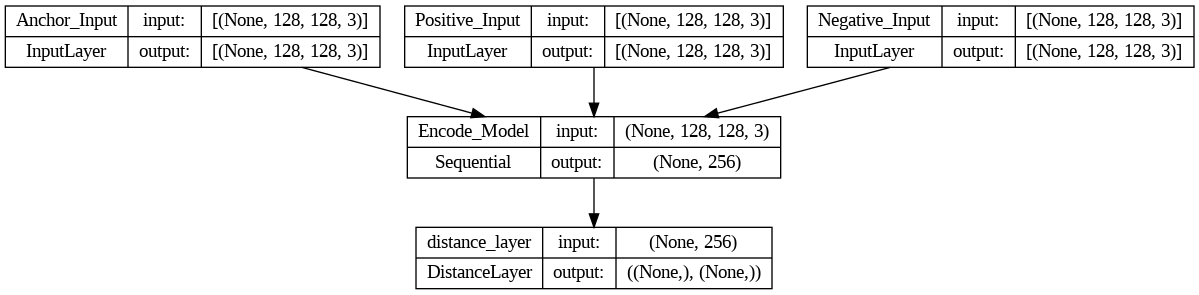

In [19]:
plot_model(siamese_network, show_shapes=True, show_layer_names=True)

### Putting everything together

We now need to implement a model with custom training loop and loss function so we can compute the **triplet loss** using the three embeddings produced by the Siamese network.

We'll create a **Mean metric** instance to track the loss of the training process.

**Triplet Loss Function:**

<img src="https://miro.medium.com/max/1838/0*AX2TSZNk19_gDgTN.png" alt="Loss Formula" width="400"/>

In [20]:
class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()
        
        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
            
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]

In [21]:
siamese_model = SiameseModel(siamese_network)

optimizer = Adam(learning_rate=1e-3, epsilon=1e-01)
siamese_model.compile(optimizer=optimizer)

In [22]:
siamese_model.built = True
siamese_model.load_weights('/content/drive/MyDrive/deep learning/copy123/MS2_model_XceptionAVG_Weightsh5_epoch16') 
siamese_model.compile(optimizer=optimizer)

## **Training the Model**

We'll now be training the siamese_model on batches of triplets. We'll print the training loss, along with additional metrics from testing every epoch. The model weights will also be saved whenever it outperforms the previous max_accuracy.

We're hoping to collect more metrics about the model to evaluate how to increase the accuracy of the model. The epochs have been set to avoid going over Kaggle's time constraint.

### Test Function

**val_on_triplets()** function will be responsible for testing the model on test_triplets. It'll collect metrics **(accuracy, means, stds)** by predicting on the train data. We'll also be printing the Accuracy of the model after testing.

In [23]:
def val_on_triplets(batch_size = 256):
    pos_scores, neg_scores = [], []

    for data in get_batch(val_triplet, batch_size=batch_size):
        prediction = siamese_model.predict(data)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])
    
    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)
    
    print(f"Accuracy on test = {accuracy:.5f}")
    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)

In [24]:
max_accuracy = 0.990677966101695

In [ ]:
from tensorflow.keras.models import save_model

save_all = False
epochs = 180
batch_size = 128

local_max_acc = max_accuracy 
train_loss = []
test_metrics = []


for epoch in range(1, epochs+1):
    t = time.time()
    
    # Training the model on train data
    epoch_loss = []
    for data in get_batch(train_triplet, batch_size=batch_size, preprocess = True, augment=True, shuffle = True, ScaleOfAugmentation = 5):
        loss = siamese_model.train_on_batch(data)
        epoch_loss.append(loss)
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    train_loss.append(epoch_loss)
   # myFile = open("/content/drive/MyDrive/Spring 23/Deep Learning/TrainLoss.txt", 'a') #abdullah
    myFile = open("/content/drive/MyDrive/deep learning/copy123/TrainLoss_MS2_2.txt", 'a') #rafik
    myFile.write(str(epoch_loss)+' ')
    myFile.close()

    print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
    print(f"Loss on train    = {epoch_loss:.5f}")
    
    # Testing the model on test data
    metric = val_on_triplets(batch_size=batch_size)
    test_metrics.append(metric)
    accuracy = metric[0]
    #myFile = open("/content/drive/MyDrive/Spring 23/Deep Learning/TrainMetric.txt", 'w') #abdullah
    myFile = open("/content/drive/MyDrive/deep learning/copy123/TrainMetric2_MS2_2.txt", 'w') #rafik
    np.savetxt(myFile,test_metrics)
    myFile.close()
    
    # Saving the model weights
    if save_all or accuracy>=local_max_acc:
        #siamese_model.save_weights(filepath="/content/drive/MyDrive/Spring 23/Deep Learning/" + "siamese_model_RN50_1_1")#abdullah
        #siamese_model.save("/content/drive/MyDrive/deep learning/model_Xception_epoch" + str(epoch),save_format='h5')
        #siamese_model.save("/content/drive/MyDrive/deep learning/model_XceptionAVG_epoch" + str(epoch),save_format='tf')
        #save_model(siamese_model, "model_Xception_epoch" + str(epoch) +".h5")
        siamese_model.layers[0].save_weights(filepath="/content/drive/MyDrive/deep learning/copy123/MS2_model_XceptionAVG_Weightsh5_epoch" + str(epoch),save_format='h5')#rafik        
        #siamese_model.save_weights(filepath="/content/drive/MyDrive/deep learning/model_Xception2Weightstf_epoch" + str(epoch),save_format='tf')#rafik        
        max_accuracy = accuracy
        local_max_acc = accuracy

# Saving the model after all epochs run

siamese_model.save_weights("/content/drive/MyDrive/deep learning/" + "siamese_model_finalh5_XceptionAVGWeights_"+str(epoch),save_format='h5') #rafik


KeyboardInterrupt: ignored

In [25]:
print("maximum accuracy reached during training: ",max_accuracy *100,"%")

maximum accuracy reached during training:  99.0677966101695 %


## **Evaluating the Model**


In [26]:
def plot_metrics(loss, metrics):
    # Extracting individual metrics from metrics
    accuracy = metrics[:, 0]
    ap_mean  = metrics[:, 1]
    an_mean  = metrics[:, 2]
    ap_stds  = metrics[:, 3]
    an_stds  = metrics[:, 4]
    
    plt.figure(figsize=(15,5))
    
    # Plotting the loss over epochs
    plt.subplot(121)
    plt.plot(loss, 'b', label='Loss')
    plt.title('Training loss')
    plt.legend()
    
    # Plotting the accuracy over epochs
    plt.subplot(122)
    plt.plot(accuracy, 'r', label='Accuracy')
    plt.title('Testing Accuracy')
    plt.legend()
    
    plt.figure(figsize=(15,5))
    
    # Comparing the Means over epochs
    plt.subplot(121)
    plt.plot(ap_mean, 'b', label='AP Mean')
    plt.plot(an_mean, 'g', label='AN Mean')
    plt.title('Means Comparision')
    plt.legend()
    
    # Plotting the accuracy
    ap_75quartile = (ap_mean+ap_stds)
    an_75quartile = (an_mean-an_stds)
    plt.subplot(122)
    plt.plot(ap_75quartile, 'b', label='AP (Mean+SD)')
    plt.plot(an_75quartile, 'g', label='AN (Mean-SD)')
    plt.title('75th Quartile Comparision')
    plt.legend()



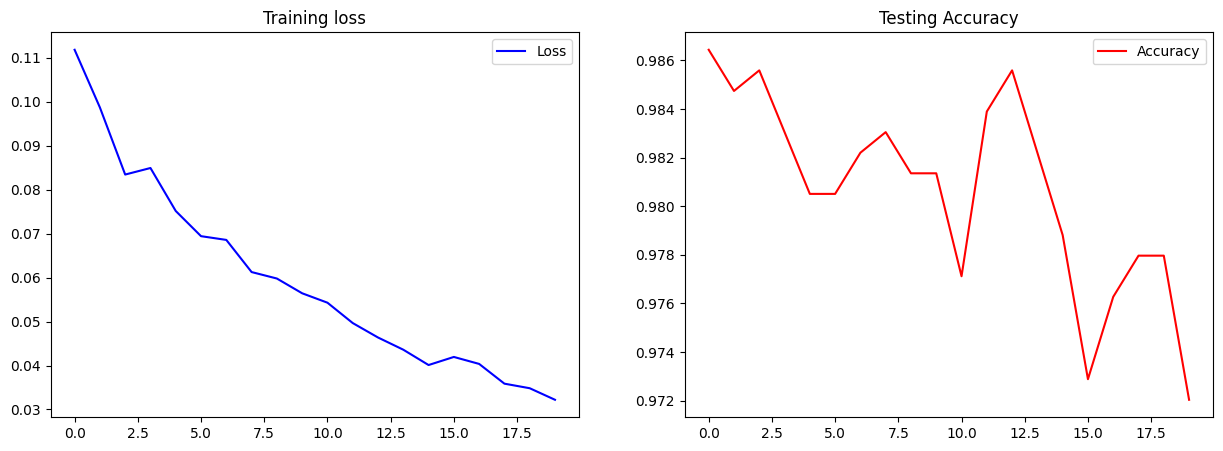

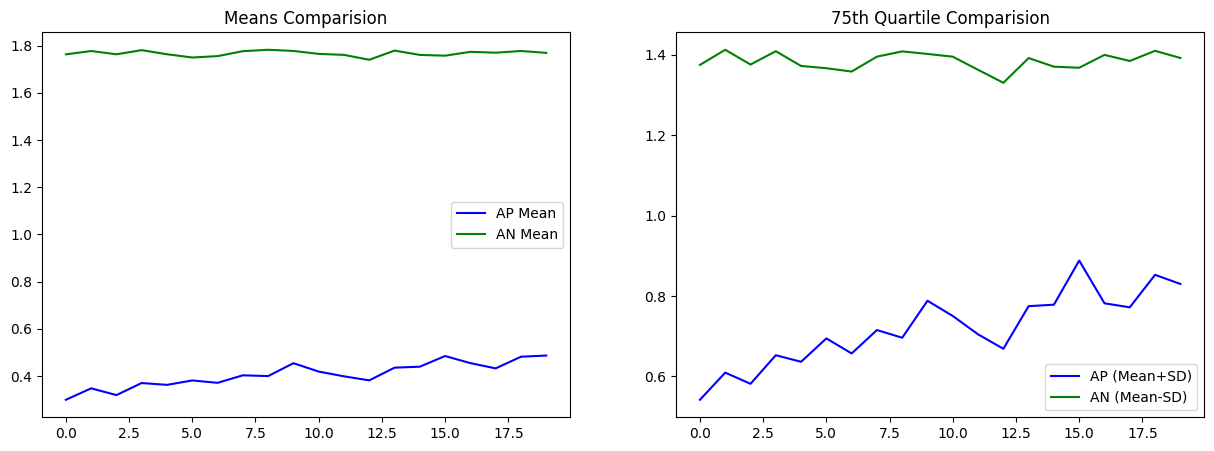

In [27]:
from numpy import loadtxt

testpath="/content/drive/MyDrive/deep learning/copy123/TrainMetric2_MS2_2.txt"
trainpath = "/content/drive/MyDrive/deep learning/copy123/TrainLoss_MS2_2.txt"

# trainpath = '/content/drive/MyDrive/deep learning/plotting/TrainLoss.txt'
# testpath = '/content/drive/MyDrive/deep learning/plotting/TrainMetric.txt'

test_metrics_loaded = loadtxt (testpath, comments="#",delimiter = " ", unpack=False)

text_file = open(trainpath, "r")
train_loss_loaded = text_file.read().split(" ")

train_loss_loaded = np.array(train_loss_loaded)
#train_loss_loaded_2 = np.delete(train_loss_loaded,15) 

train_loss_loaded = train_loss_loaded[0:len(train_loss_loaded)-1].astype(np.float32)

plot_metrics(train_loss_loaded, test_metrics_loaded)

## **Using the Model**

Now that we've finished training our model, we need to **extract the encoder** so that we can use it to encode images and then get use the feature vectors to compute the distance between those images.

We'll also be saving the encoder for latter use.

In [28]:
def extract_encoder(model):
    encoder = get_encoder((128, 128, 3))
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

encoder = extract_encoder(siamese_model)
encoder.save_weights("encoder")
encoder.summary()

Model: "Encode_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_9 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 lambda_1 (Lambda)           (None, 256)               0         
                                                      

### Classify Images

To compute the distance between the encodings of the images, we'll be using distance formula. Distance over a certain threshold to be "different" and below the threshold as "same".

In [29]:
def classify_images(face_list1, face_list2, threshold=1.3,prnt=False):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(face_list1)
    tensor2 = encoder.predict(face_list2)
    
    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1) # simillar => 0 || Different => 1
    if prnt == True:
      print("Distance:",distance)
      PredStr = "Same Person" if not(prediction[0]) else "Different"
      print("prediction is",PredStr)
    return prediction

In [44]:
!pip install deepface
from deepface import DeepFace
from deepface.commons import functions
from PIL import Image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
def Detect_Align_Img(path,target_size = (128,128)):
  img1 = DeepFace.extract_faces(img_path = path,enforce_detection=False) # https://github.com/serengil/deepface/blob/master/deepface/DeepFace.py
  img1 = np.array(img1[0]['face'])
  img1 = cv2.resize(img1,target_size)
  return img1

def showImg(imgArray):
  plt.imshow(imgArray)

In [32]:
arr = get_Images_Anc(train_triplet,2000)
np.array(arr).shape

(2000, 128, 128, 3)

In [33]:
def verifyImages(refImagePath,ImgToPredPath):
  refImageOrig = Image.open(refImagePath)

  predImageOrig = Image.open(ImgToPredPath)


  f,axes = plt.subplots(1, 2, figsize=(5, 5))
  axes[0].imshow(refImageOrig)
  axes[1].imshow(predImageOrig)


  refImage = Detect_Align_Img(refImagePath)
  predImage = Detect_Align_Img(ImgToPredPath)

  # f,axes = plt.subplots(1, 2, figsize=(5, 5))
  # axes[0].imshow(refImage)
  # axes[1].imshow(predImage)

  refImage = refImage*255
  refImage = refImage.astype(np.uint8)
  predImage = predImage*255
  predImage = predImage.astype(np.uint8)

  preproArr = arr


  preproArr[0] = refImage
  preproArr[1] = predImage

  preproArr = preprocess_input(np.array(preproArr))


  refImage = preproArr[0] 
  predImage = preproArr[1]



  # f,axes = plt.subplots(1, 2, figsize=(5, 5))
  # axes[0].imshow(refImage)
  # axes[1].imshow(predImage)


  # refImage = preprocess_input(refImage)
  # predImage = preprocess_input(predImage)


  refImage = np.expand_dims(refImage, axis=0)
  predImage = np.expand_dims(predImage, axis=0)

  print("Ref Image shape",refImage.shape)
  print("Pred Image shape",predImage.shape)
  pred = classify_images(refImage,predImage,1.35,prnt=True)

Ref Image shape (1, 128, 128, 3)
Pred Image shape (1, 128, 128, 3)
1/1 [==============================] - 0s 23ms/step
Distance: [1.6597979]
prediction is Different


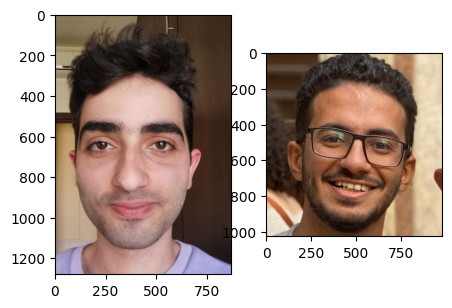

In [36]:
verifyImages("/content/Abdullah1.jpeg","/content/Rafik1.jpeg")

Ref Image shape (1, 128, 128, 3)
Pred Image shape (1, 128, 128, 3)
1/1 [==============================] - 0s 37ms/step
Distance: [0.46371934]
prediction is Same Person


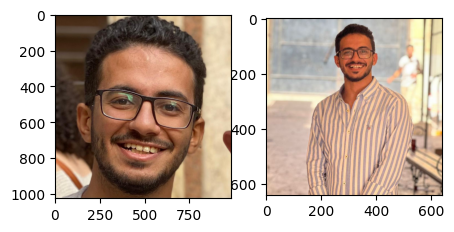

In [56]:
verifyImages("/content/Rafik1.jpeg","/content/Rafik2.jpg")

Ref Image shape (1, 128, 128, 3)
Pred Image shape (1, 128, 128, 3)
1/1 [==============================] - 0s 22ms/step
Distance: [1.5097067]
prediction is Different


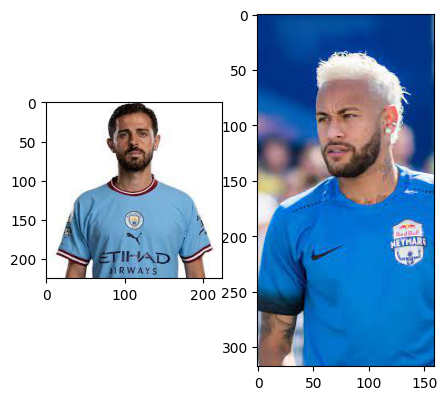

In [57]:
verifyImages("/content/Bernardo1.jpeg","/content/Neymar1.jpeg")

Ref Image shape (1, 128, 128, 3)
Pred Image shape (1, 128, 128, 3)
1/1 [==============================] - 0s 22ms/step
Distance: [1.2010156]
prediction is Same Person


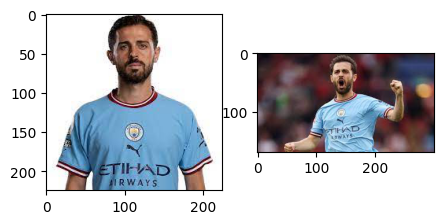

In [58]:
verifyImages("/content/Bernardo1.jpeg","/content/Bernardo2.jpeg")

# **Live Demo**

**Face Verification Video reference:** 
https://www.youtube.com/watch?v=YjWh7QvVH60 - https://colab.research.google.com/drive/1QnC7lV7oVFk5OZCm75fqbLAfD9qBy9bw?usp=sharing

In [45]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
from PIL import *
import io
import html
import time

In [46]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [47]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

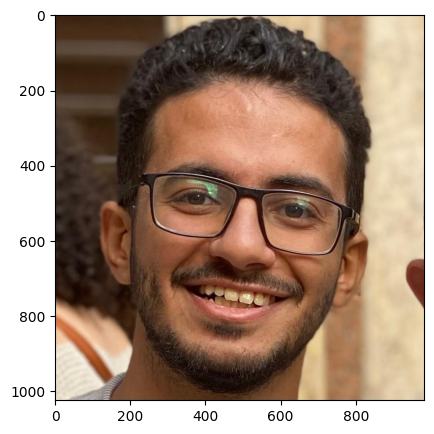

In [48]:
ReferenceIMGPath = "/content/Rafik1.jpeg"
dispImg = Image.open(ReferenceIMGPath)
f,axes = plt.subplots(1, 1, figsize=(5, 5))
axes.imshow(dispImg)

In [49]:
arr = get_Images_Anc(train_triplet,2000)
refImage = Detect_Align_Img(ReferenceIMGPath)
refImage = refImage*255
refImage = refImage.astype(np.uint8)

preproArr = arr
preproArr[0] = refImage
preproArr = preprocess_input(np.array(preproArr))
refImage = preproArr[0] 
refImage = np.expand_dims(refImage, axis=0)
# refImage.shape

In [50]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    predImage = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    predImage = Detect_Align_Img(predImage)
    

    predImage = predImage*255
    predImage = predImage.astype(np.uint8)

    preproArr = arr
    preproArr[1] = predImage
    preproArr = preprocess_input(np.array(preproArr))
    predImage = preproArr[1] 
    predImage = np.expand_dims(predImage, axis=0)

    # get face region coordinates
    # faces = face_cascade.detectMultiScale(gray)
    pred = classify_images(refImage,predImage,1.35,prnt=True)
    print(pred)
    

    # # get face bounding box for overlay
    # for (x,y,w,h) in faces:
    #   bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)

    # bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # # convert overlay of bbox into bytes
    # bbox_bytes = bbox_to_bytes(bbox_array)
    # # update bbox so next frame gets new overlay
    # bbox = bbox_bytes

1/1 [==============================] - 0s 20ms/step
Distance: [1.7443066]
prediction is Different
[1]


MessageError: ignored

40/40 [==============================] - 2s 38ms/step

Accuracy of model: 93.6078431372549 %
Recall: 96.54901960784314 %
Precision: 91.18518518518518 %
F1 score: 93.79047619047618 %
AUC: 93.6078431372549 %
Categorical Cross-entropy: 2.3039668636965085


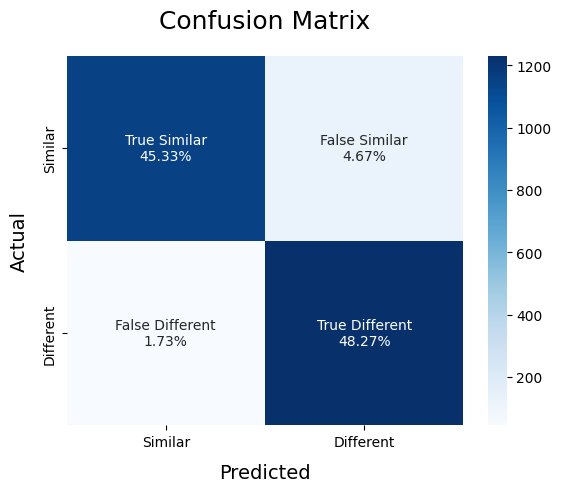

In [55]:
def ModelMetrics(pos_list, neg_list):
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)
    
    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)* 100} %")
    
    # Compute and print the recall
    print(f"Recall: {recall_score(true, pred)* 100} %")
    
    # Compute and print the precision
    print(f"Precision: {precision_score(true, pred)* 100} %")
    
    # Compute and print the F1 score
    print(f"F1 score: {f1_score(true, pred)* 100} %")
    
    # Compute and print the AUC score
    print(f"AUC: {roc_auc_score(true, pred)* 100} %")
    
    # Compute and print the categorical cross-entropy
    print(f"Categorical Cross-entropy: {log_loss(true, pred)}")
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Similar','Different']
    names = ['True Similar','False Similar', 'False Different','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)




pos_list = np.array([])
neg_list = np.array([])

for data in get_batch(test_triplet, batch_size=len(test_triplet)):
    a, p, n = data
    pos_list = np.append(pos_list, classify_images(a, p, 0.8))
    neg_list = np.append(neg_list, classify_images(a, n, 0.8))
    break

ModelMetrics(pos_list, neg_list)

## References

- FaceNet: A Unified Embedding for Face Recognition and Clustering: https://arxiv.org/abs/1503.03832
- Image similarity estimation using a Siamese Network with a triplet loss: https://keras.io/examples/vision/siamese_network/
- Celebrity Face Recognition: https://www.kaggle.com/ravehgillmore/celebrity-face-recognition/
- Face Recognition using Siamese Networks: https://medium.com/wicds/face-recognition-using-siamese-networks-84d6f2e54ea4
